In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
sales_train = pd.read_csv('sales_train.csv')
item_cat = pd.read_csv('item_categories.csv')
items = pd.read_csv('items.csv')
shops = pd.read_csv('shops.csv')
sample_submission = pd.read_csv('sample_submission.csv')
test = pd.read_csv('test.csv')

# Data Audit

In [3]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [4]:
item_cat.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [5]:
sales_train.tail()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2935844,10.10.2015,33,25,7409,299.0,1.0
2935845,09.10.2015,33,25,7460,299.0,1.0
2935846,14.10.2015,33,25,7459,349.0,1.0
2935847,22.10.2015,33,25,7440,299.0,1.0
2935848,03.10.2015,33,25,7460,299.0,1.0


In [6]:
sales_train.shape

(2935849, 6)

In [7]:
sales_train.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day'],
      dtype='object')

In [8]:
sales_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [9]:
sales_train.isna() .sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [10]:
sales_train.describe() .round()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2935849.0,2935849.0,2935849.0,2935849.0,2935849.0
mean,15.0,33.0,10197.0,891.0,1.0
std,9.0,16.0,6324.0,1730.0,3.0
min,0.0,0.0,0.0,-1.0,-22.0
25%,7.0,22.0,4476.0,249.0,1.0
50%,14.0,31.0,9343.0,399.0,1.0
75%,23.0,47.0,15684.0,999.0,1.0
max,33.0,59.0,22169.0,307980.0,2169.0


# Data Cleaning

In [11]:
#grouped the numberic data
nst = sales_train.select_dtypes(include=['int64', 'float64'])
nst.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_price', 'item_cnt_day'], dtype='object')

Text(0.5, 0, 'Attributes')

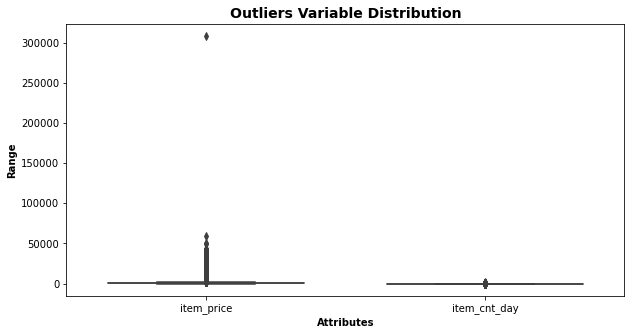

In [12]:
#finding the outliers on item_price and item_cnt_day

attributes = ['item_price','item_cnt_day']
plt.rcParams['figure.figsize'] = [10,5]
sns.boxplot(data = sales_train[attributes], width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [13]:
#removing outliers from item_price

Q1 = sales_train['item_price'].quantile(0.25)
Q3 = sales_train['item_price'].quantile(0.75)

IQR = Q3 - Q1
boxplot_min = Q1 - 1.5 * IQR
boxplot_max = Q3 + 1.5 * IQR

filter_min = sales_train['item_price']<boxplot_min
filter_max = sales_train['item_price']>boxplot_max

data_clean = sales_train[~(filter_min|filter_max)]

In [14]:
#removing outliers for item_cnt_day

Q1 = sales_train['item_cnt_day'].quantile(0.25)
Q3 = sales_train['item_cnt_day'].quantile(0.75)

IQR = Q3 - Q1
boxplot_min = Q1 - 1.5 * IQR
boxplot_max = Q3 + 1.5 * IQR

filter_min = sales_train['item_cnt_day']<boxplot_min
filter_max = sales_train['item_cnt_day']>boxplot_max

data_clean = sales_train[~(filter_min|filter_max)]

In [15]:
#checking the clean data
sales_train.shape

(2935849, 6)

In [16]:
data_clean.shape

(2629372, 6)

In [17]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2629372 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 140.4+ MB


# Feature Engineering

In [18]:
# Transforming Date

data_clean["date"]= pd.to_datetime(data_clean["date"], format='%d.%m.%Y')
data_clean.sort_values(by="date", ascending=True, inplace=True)

In [19]:
data_clean['month_year'] = data_clean['date'].apply(lambda x: x.strftime('%Y-%m'))
data_clean['year'] = data_clean['date'].apply(lambda x: x.strftime('%Y'))
data_clean['month'] = data_clean['date'].apply(lambda x: x.strftime('%m'))

In [20]:
data_clean_temp = data_clean.groupby('month_year').sum()['item_cnt_day'].reset_index()

In [21]:
# Sales per Item

data_clean['sales_item'] = data_clean['item_cnt_day'] * data_clean['item_price']

In [22]:
data_clean.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,month_year,year,month,sales_item
96070,2013-01-01,0,51,20230,260.00,1.0,2013-01,2013,01,260.00
114293,2013-01-01,0,46,3187,2499.00,1.0,2013-01,2013,01,2499.00
86975,2013-01-01,0,54,6406,349.00,1.0,2013-01,2013,01,349.00
100633,2013-01-01,0,51,18549,69.00,1.0,2013-01,2013,01,69.00
91802,2013-01-01,0,42,15761,347.89,1.0,2013-01,2013,01,347.89


In [23]:
data_clean.tail()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,month_year,year,month,sales_item
2933611,2015-10-31,33,25,16159,799.0,1.0,2015-10,2015,10,799.0
2894809,2015-10-31,33,37,2753,299.0,1.0,2015-10,2015,10,299.0
2904777,2015-10-31,33,53,9356,399.0,1.0,2015-10,2015,10,399.0
2907496,2015-10-31,33,52,2050,698.0,1.0,2015-10,2015,10,698.0
2883546,2015-10-31,33,46,3351,3999.0,1.0,2015-10,2015,10,3999.0


# Exploratory Data Analysis

<AxesSubplot:xlabel='month', ylabel='item_cnt_day'>

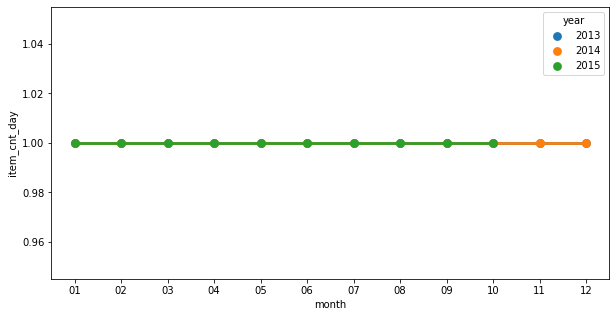

In [24]:
sns.pointplot(x='month', y='item_cnt_day', hue='year', data=data_clean)

<AxesSubplot:xlabel='month', ylabel='item_price'>

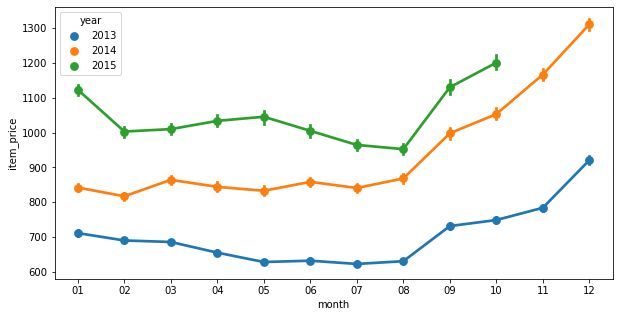

In [25]:
sns.pointplot(x='month', y='item_price', hue='year', data=data_clean)

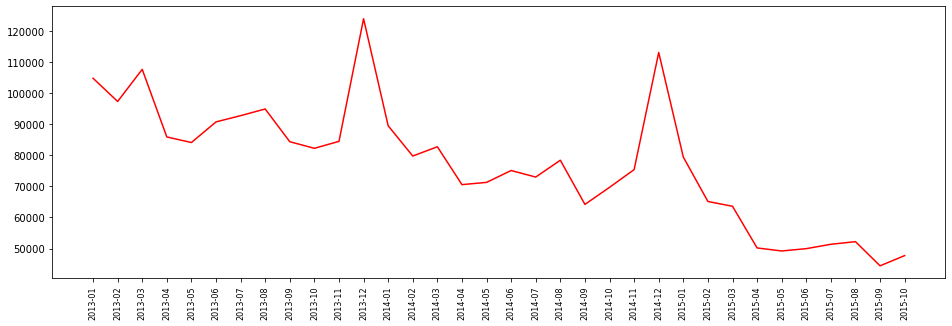

In [26]:
plt.figure(figsize=(16, 5))
plt.plot(data_clean_temp['month_year'], data_clean_temp['item_cnt_day'], color='#FF0000')
plt.xticks(rotation='vertical', size=8)
plt.show()

In [27]:
data_clean_temp = data_clean.groupby('month_year').sum()['sales_item'].reset_index()

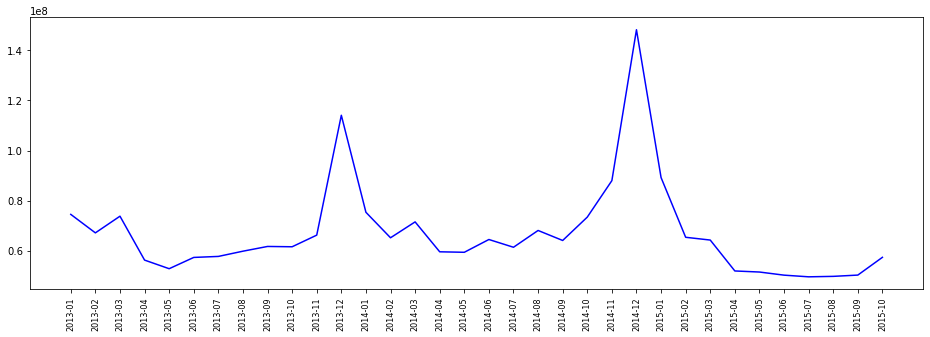

In [28]:
plt.figure(figsize=(16, 5))
plt.plot(data_clean_temp['month_year'], data_clean_temp['sales_item'], color='#0000FF')
plt.xticks(rotation='vertical', size=8)
plt.show()

In [29]:
shope_sum_temp = data_clean.groupby('shop_id').sum()['item_cnt_day'].reset_index()

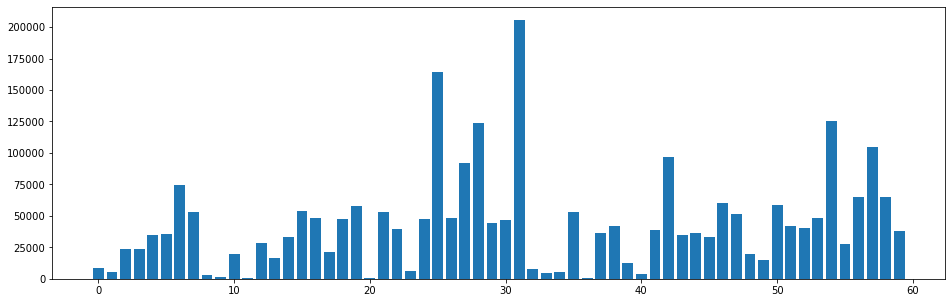

In [30]:
plt.figure(figsize=(16, 5))
plt.bar(shope_sum_temp['shop_id'], shope_sum_temp['item_cnt_day'])
plt.show()

In [31]:
top10shops = pd.DataFrame(data_clean.groupby('shop_id').sum()['item_cnt_day'])

In [32]:
top10shops.sort_values(by=['item_cnt_day'], inplace=True, ascending=False)

In [33]:
top10shops[:10]

,item_cnt_day
shop_id,
31,205671.0
25,164096.0
54,125685.0
28,123622.0
57,104466.0
42,96979.0
27,91676.0
6,74520.0
58,64847.0


# Forecasting for Future Sales

In [34]:
!pip install prophet

In [35]:
from prophet import Prophet

In [36]:
data_clean ['date'] = pd.to_datetime(sales_train ['date'])
data_clean.dtypes

date              datetime64[ns]
date_block_num             int64
shop_id                    int64
item_id                    int64
item_price               float64
item_cnt_day             float64
month_year                object
year                      object
month                     object
sales_item               float64
dtype: object

In [37]:
sales = pd.DataFrame(data_clean.groupby(['date'])['sales_item'].mean().reset_index())

In [38]:
sales.head()

,date,sales_item
0,2013-01-01,725.359293
1,2013-01-02,673.677906
2,2013-01-03,669.045028
3,2013-01-04,707.502195
4,2013-01-05,582.768711


In [39]:
sales.columns = ['ds', 'y']
sales.head()

,ds,y
0,2013-01-01,725.359293
1,2013-01-02,673.677906
2,2013-01-03,669.045028
3,2013-01-04,707.502195
4,2013-01-05,582.768711


In [40]:
p = Prophet(interval_width=0.92, daily_seasonality=True)

In [41]:
model = p.fit(sales)

Initial log joint probability = -5.72012
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        2290.2   0.000765569       86.4466      0.8543      0.8543      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2290.61   1.46663e-05        93.417           1           1      259   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     292       2290.97   0.000279928       213.161   9.805e-07       0.001      412  LS failed, Hessian reset 
     299       2291.11   0.000126013       87.4782      0.5373      0.5373      419   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     345       2291.13   5.26238e-08       64.2022      0.2881           1      483   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [42]:
future = p.make_future_dataframe(periods=200, freq='D')
future.tail()

,ds
1229,2016-06-23
1230,2016-06-24
1231,2016-06-25
1232,2016-06-26
1233,2016-06-27


In [43]:
forecast_prediction = p.predict(future)
forecast_prediction.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1229,2016-06-23,1193.287315,913.946932,1278.229637,1170.394242,1219.029933,-102.980981,-102.980981,-102.980981,-68.100684,...,5.582109,5.582109,5.582109,-40.462407,-40.462407,-40.462407,0.0,0.0,0.0,1090.306334
1230,2016-06-24,1193.432840,902.153125,1274.392752,1170.556877,1219.477607,-103.548981,-103.548981,-103.548981,-68.100684,...,3.478994,3.478994,3.478994,-38.927291,-38.927291,-38.927291,0.0,0.0,0.0,1089.883859
1231,2016-06-25,1193.578365,878.459721,1259.826978,1170.719513,1219.925281,-120.060880,-120.060880,-120.060880,-68.100684,...,-14.136374,-14.136374,-14.136374,-37.823823,-37.823823,-37.823823,0.0,0.0,0.0,1073.517485
1232,2016-06-26,1193.723890,879.182307,1251.926315,1170.723710,1220.311436,-126.980164,-126.980164,-126.980164,-68.100684,...,-21.654713,-21.654713,-21.654713,-37.224767,-37.224767,-37.224767,0.0,0.0,0.0,1066.743726
1233,2016-06-27,1193.869415,926.402299,1287.233056,1170.711140,1220.603263,-96.395725,-96.395725,-96.395725,-68.100684,...,8.893786,8.893786,8.893786,-37.188827,-37.188827,-37.188827,0.0,0.0,0.0,1097.473690


Text(53.5, 0.5, 'Sales')

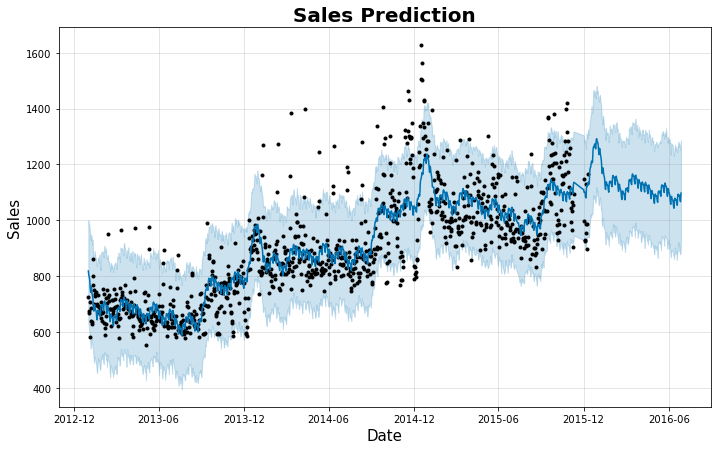

In [52]:
plot1 = p.plot(forecast_prediction)
plt.title("Sales Prediction", size=20, fontweight='bold')
plt.xlabel("Date", size=15)
plt.ylabel("Sales", size=15)

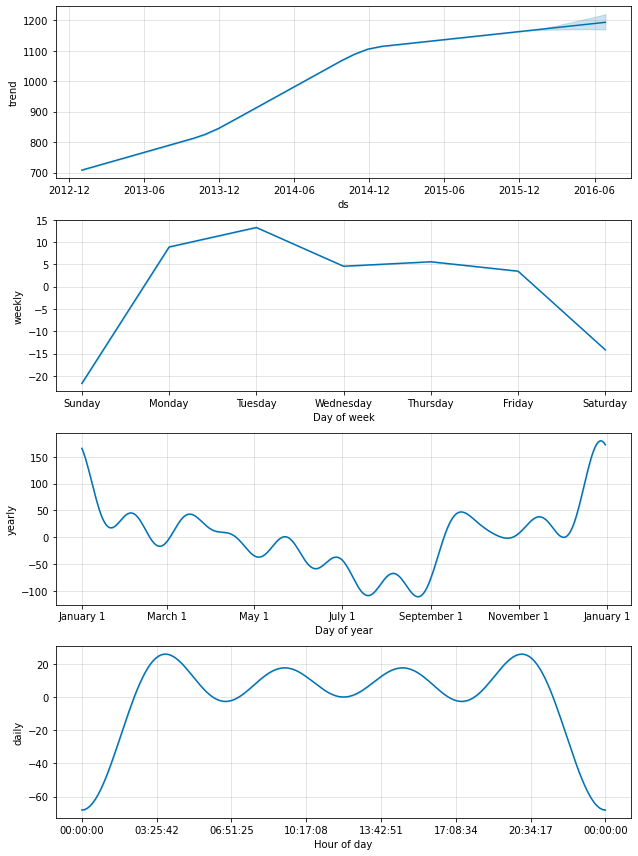

In [45]:
plot2 = p.plot_components(forecast_prediction)